<a href="https://colab.research.google.com/github/ziqlu0722/Mouse-Brain-Image-Classifier/blob/master/MouseBrainImageClassifier_notebook_ZiqingLu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mouse Brain Image Classifier NoteBook

Author: Ziqing Lu

# 1. SETUP

## 1.1 Import Libraries

In [0]:
import tensorflow as tf
tf.enable_eager_execution()
tf.executing_eagerly()
RANDOM_STATE = 1

import os
import numpy as np
import random
import datetime
import cv2

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical

from tensorboard.plugins.hparams import api as hp

Using TensorFlow backend.


## 1.2 Mount Drive to Google Colab

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = '/content/drive/My Drive/MouseBrain-ImageClassifier'

os.chdir(path)

# 2. PROCESS DATA 

### Done with local jupyter notebook

In [0]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from PIL import Image, ImageOps

mag_level = '3'

## 2.1 Untar Data

In [0]:
import tarfile

path = os.getcwd()

fname_list = []
for root, dirs, files in os.walk(path):
    for f in files:
        if f.endswith('.tar'):
            f_path = os.path.join(root,f)
            fname_list.append(f_path)

for f_path in fname_list:
    try:
        with tarfile.open(f_path) as tar:
            tar.extractall()
    except:
        print('file could not be opened successully: {}'.format(f_path))

## 2.2 Imgage Pieces Random Check

In [0]:
def image_from_dir(pic_dir, mag_level = '3', show = False):
    files = os.listdir(pic_dir)
    imagePaths = []
    for f in files:
        if f[-9] == mag_level and f.endswith('.jpg'):
            f_path = os.path.join(pic_dir,f)
            imagePaths.append(f_path)
    imagePaths.sort(key = lambda x: (x[-5], x[-7]))
    y_ = int(max(_[-5] for _ in imagePaths))+1
    x_ = int(max(_[-7] for _ in imagePaths))+1
                
    if show == True:
        for i in imagePaths:  
            img = cv2.imread(i)
            print('img filename is {}; img size is {}'.format(i[-9:], img.shape))
    
    return imagePaths, x_, y_

def plot(paths, x_, y_):
    plt.figure(figsize = (15, 12))
    plt.tight_layout()
    for i in range(len(paths)):
        img = cv2.imread(paths[i])
        ax = plt.subplot(y_, x_, i+1)
        ax.imshow(img)
        ax.set_ylim(300, 0)
        ax.set_xlim(0, 300)
        ax.set_title(paths[i][-9:-4])

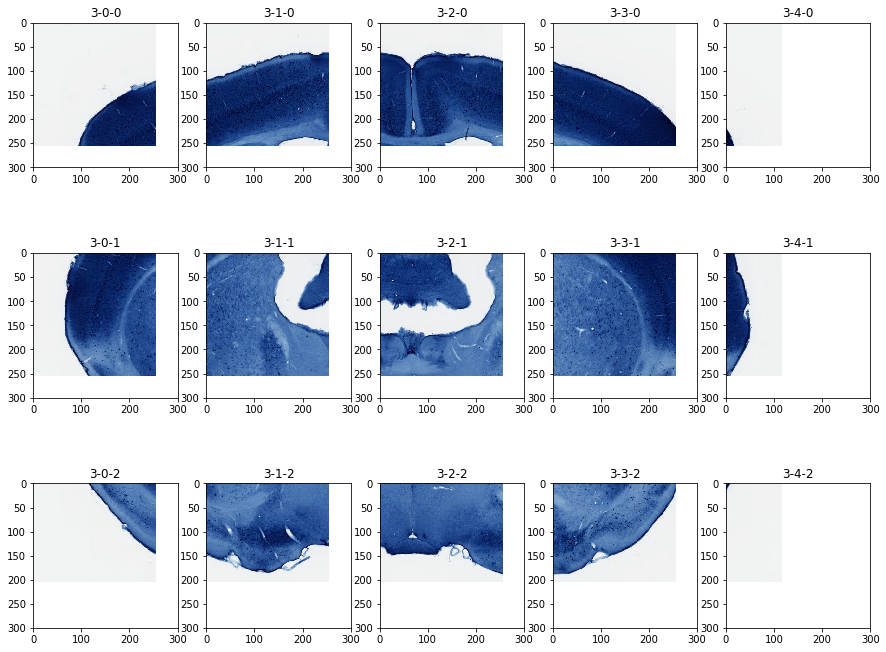

In [0]:
sample_1 = '/Users/lvziqing/Desktop/MachineLearning/3-Projects/Brain-ImageClassifier/HBP2/mus.musculus/cor/001-parv/p31/TileGroup0/'
plot(*image_from_dir(sample_1))

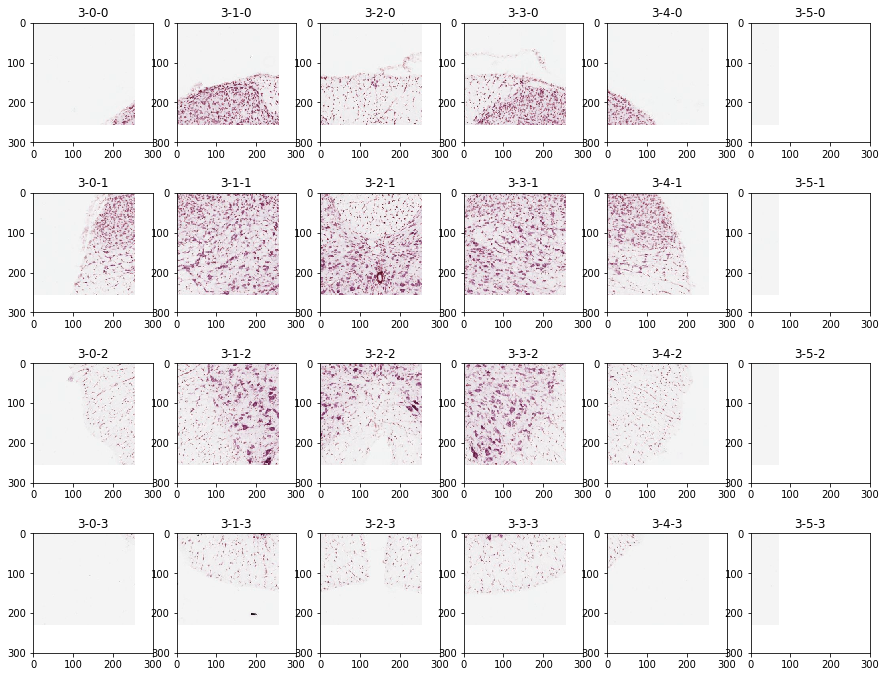

In [0]:
sample_2 = '/Users/lvziqing/Desktop/MachineLearning/3-Projects/Brain-ImageClassifier/HBP2/mus.musculus/cor/002-nissl/m22c/TileGroup0/'
plot(*image_from_dir(sample_2))


### Need to build a flexible function as the number of pieces of each image are different

## 2.3 Stitch Images With Magnificant Level 3

In [0]:
def get_album(path):
    albumDetails = []
    for root, dirs, files in os.walk(path):
        for d in dirs:
            if d == 'TileGroup0':
                pic_dir = root + '/TileGroup0/'
                imagePaths, x_, y_ = image_from_dir(pic_dir)
                albumDetails.append((pic_dir, imagePaths, x_, y_))
    return albumDetails
   
def data_processing(dirs, save_path, mag_level = 3):
    
    error_cnt = 0
    processed_cnt = 0
    for i in range(len(dirs)):
        mag_level = mag_level
        s_path = save_path + str(i) + '.jpg'
        try:
            __stiching(dirs[i][0],dirs[i][2], dirs[i][3], s_path, mag_level)
            processed_cnt += 1
        except:
            error_cnt += 1
            print('error with: {}'.format(dirs[i][0]))
    print('total {} errors'.format(error_cnt))
    print('total {} processed picture'.format(processed_cnt))
            

def __stiching(path, _x, _y, save_path = None, mag_level = '3', show=False):
    rows = []
    for x in range(_x):
        img_arr_list = []    
        for y in range(_y):
            img_fname = '-'.join([str(mag_level), str(x), str(y)])+'.jpg'
            img_path = path + img_fname
            img_arr = cv2.imread(img_path)
            img_arr_list.append(img_arr)
        rows.append(np.concatenate(img_arr_list, axis = 0))

    img = np.concatenate(rows, axis = 1)
    
    if show == True:
        plt.imshow((img).astype(np.uint8))
    if save_path:
        cv2.imwrite(save_path, img)

In [0]:
cor_path = os.getcwd() + '/HBP2/mus.musculus/cor'
save_path = os.getcwd() + '/data/cor/'
data_processing(get_album(cor_path), save_path)

total 0 errors
total 357 processed picture


In [0]:
hor_path = os.getcwd() + '/HBP2/mus.musculus/hor'
save_path = os.getcwd() + '/data/hor/'
data_processing(get_album(hor_path), save_path)

total 0 errors
total 168 processed picture


In [0]:
sag_path = os.getcwd() + '/HBP2/mus.musculus/sag'
save_path = os.getcwd() + '/data/sag/'
data_processing(get_album(sag_path), save_path)

total 0 errors
total 179 processed picture


## 2.4 Plot A Few Examples To Check

In [0]:
def plotCollection(path):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        img_path = os.path.join(path, os.listdir(path)[i])
        img = cv2.imread(img_path)
        ax = plt.subplot(3, 3, i+1)
        ax.imshow(img)
        ax.set_title(os.listdir(path)[i])
        print('size of the stitched pic is {}'.format(img.shape))

size of the stitched pic is (888, 1920, 3)
size of the stitched pic is (562, 1170, 3)
size of the stitched pic is (515, 1050, 3)
size of the stitched pic is (579, 1170, 3)
size of the stitched pic is (888, 1500, 3)
size of the stitched pic is (1003, 1980, 3)
size of the stitched pic is (928, 1860, 3)
size of the stitched pic is (888, 1500, 3)
size of the stitched pic is (1003, 1980, 3)


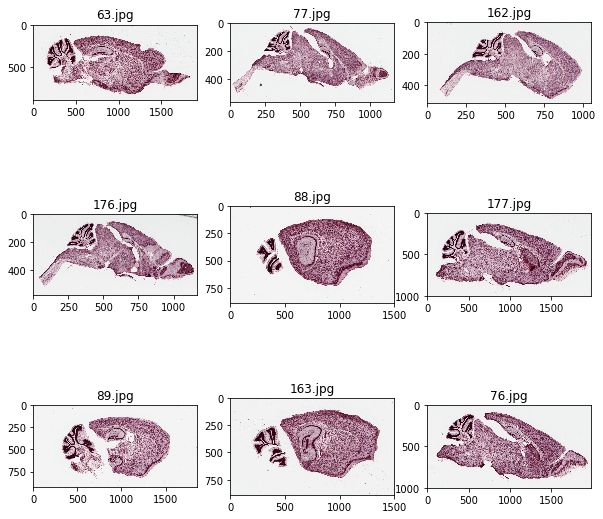

In [0]:
path =  os.getcwd() + '/data/sag/'     
plotCollection(path)

size of the stitched pic is (813, 1260, 3)
size of the stitched pic is (806, 1140, 3)
size of the stitched pic is (1166, 1560, 3)
size of the stitched pic is (1098, 1440, 3)
size of the stitched pic is (773, 1140, 3)
size of the stitched pic is (901, 1500, 3)
size of the stitched pic is (1031, 1440, 3)
size of the stitched pic is (806, 1080, 3)
size of the stitched pic is (963, 1320, 3)


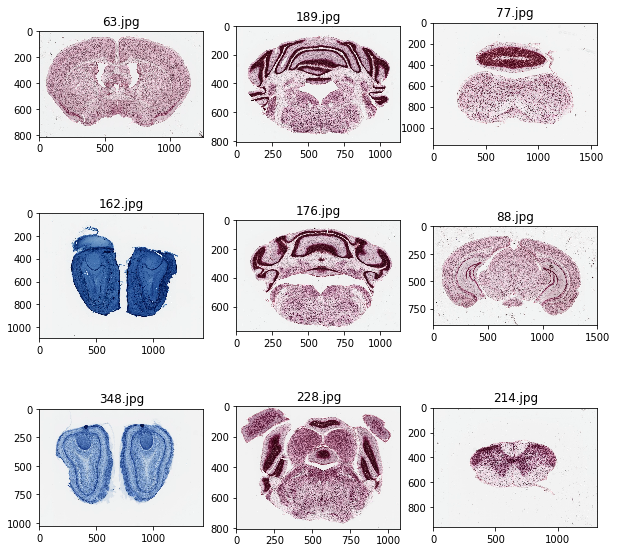

In [0]:
path =  os.getcwd() + '/data/cor/'     
plotCollection(path)

size of the stitched pic is (1170, 992, 3)
size of the stitched pic is (1995, 1712, 3)
size of the stitched pic is (1310, 992, 3)
size of the stitched pic is (1477, 1200, 3)
size of the stitched pic is (1606, 1200, 3)
size of the stitched pic is (1166, 956, 3)
size of the stitched pic is (1070, 744, 3)
size of the stitched pic is (1294, 916, 3)
size of the stitched pic is (1162, 824, 3)


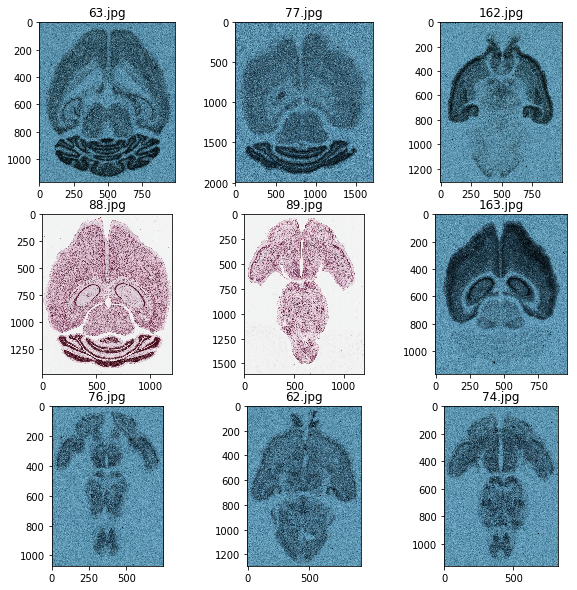

In [0]:
path =  os.getcwd() + '/data/hor/'     
plotCollection(path)

## 2.5 Resize Stitched Pictures To Unified Square Size (512*512)

In [0]:
from PIL import Image, ImageOps

def _pad_square_resize_image(img_path, desired_size, save_path=None, show=True):
  
  """ This function firstly resize the longer side of original picture to desired size, 
      then padded the short side with edge color of the original image
      
  Args:
    img_path: path
    desired_size: same for x and y, as this is for square image
  
  """
    im = Image.open(img_path)
    old_size = im.size
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im = im.resize(new_size, Image.ANTIALIAS)
    pad_color = tuple(np.asarray(im)[0][0])
    new_im = Image.new("RGB", (desired_size, desired_size), pad_color)
    new_im.paste(im, ((desired_size-new_size[0])//2, (desired_size-new_size[1])//2))
    
    if save_path:
        new_im.save(save_path)
    
    if show:
         plt.imshow(new_im)
            
    return new_im

(1170, 596)


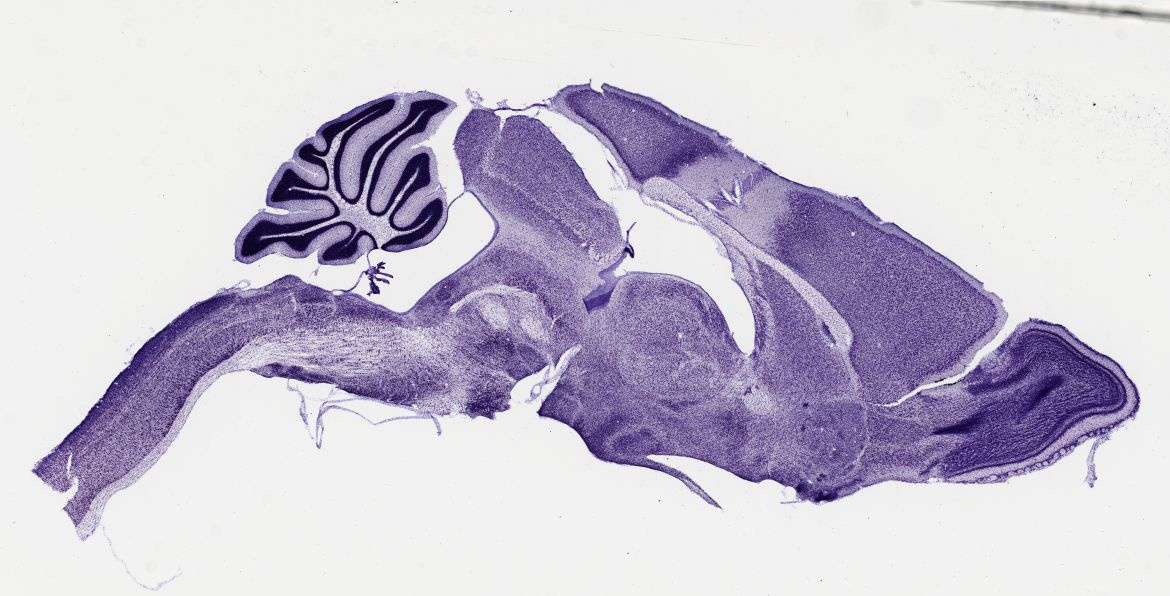

In [0]:
# test on a test picture
im_pth = "/Users/lvziqing/Downloads/test_resize/6.jpg"
im = Image.open(im_path)
print(im.size)
im

(512, 512)


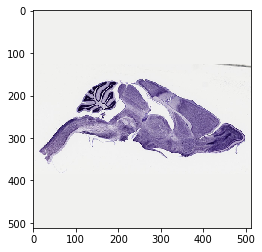

In [0]:
# resize it to 512 * 512
desired_size = 512

new_img = _pad_square_resize_image(im_pth, desired_size)
print(new_img.size)

### Looks good, now get started transforming all pictures

In [0]:
def image_pad_resize(path, s_path, desired_size):
    img_paths = []
    for f in os.listdir(path):
        if f.endswith('.jpg'):
            p = os.path.join(path, f)
            img_paths.append(p)

    for i in range(len(img_paths)):
        img_path = os.path.join(path, os.listdir(path)[i])
        save_path = s_path + str(i) + '.jpg'
        _pad_square_resize_image(img_paths[i], desired_size, 
                                 save_path=save_path, show=False)
        
    print('Total {} images have been resized'.format(len(img_paths)))

In [0]:
path = os.getcwd() + '/data/hor/'
s_path = os.getcwd()+ '/resized/hor/'
desired_size = 512
image_pad_resize(path, s_path, desired_size)

Total 168 images have been resized


In [0]:
path = os.getcwd() + '/data/cor/'
s_path = os.getcwd()+ '/resized/cor/'
desired_size = 512
image_pad_resize(path, s_path, desired_size)

Total 357 images have been resized


In [0]:
path = os.getcwd() + '/data/sag/'
s_path = os.getcwd()+ '/resized/sag/'
desired_size = 512
image_pad_resize(path, s_path, desired_size)

Total 179 images have been resized


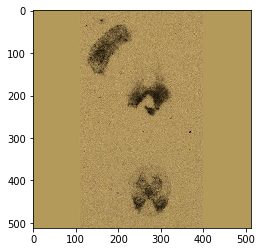

In [0]:
# check random samples of resized pictures
img_path = os.getcwd()+ '/resized/hor/37.jpg'
im = Image.open(img_path)
plt.imshow(im)

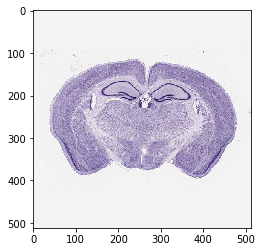

In [0]:
# check random samples of resized pictures
img_path = os.getcwd()+ '/resized/cor/37.jpg'
im = Image.open(img_path)
plt.imshow(im)

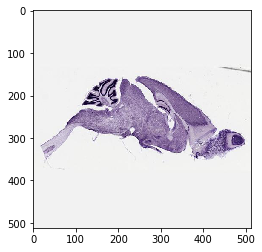

In [0]:
# check random samples of resized pictures
img_path = os.getcwd()+ '/resized/sag/37.jpg'
im = Image.open(img_path)
plt.imshow(im)

## 2.6 Load and resize data

* This load_data function 
  * reads pixel value from images, resizes them to desired square size,  nomarlizes values, and stores them in arrays, 
  * grabs image labels, and stores them in arrays

In [0]:
def load_data(path, desired_size):
  """Load images from path, resize, normalize
  
  Args:
    path: string
    desired_size: int
    rtype: tuple of two arrays
  """
  
  print("[INFO] loading images...")
  data = []
  labels = []
  imagePaths = []
  # grab the image paths and randomly shuffle them
  for root, dirs, files in os.walk(path):
    for f in files:
        if f.endswith('.jpg'):
            f_path = os.path.join(root,f)
            imagePaths.append(f_path)

  # loop over the input images
  for imagePath in imagePaths:
      # load the image, and store it in the data list
      image = cv2.imread(imagePath)
      image = cv2.resize(image, (desired_size, desired_size))
      image = img_to_array(image)
      data.append(image)

      # extract the class label from the image path
      label = imagePath.split(os.path.sep)[-2] 
      label_dict = {'cor':0., 'hor':1., 'sag':2.}
      label_int = int(label_dict.get(label))
      labels.append(label_int)

  # scale the raw pixel intensities to the range[0,1]
  data = np.array(data)/255.0

  # convert the labels from integers to vectors
  labels = to_categorical(labels, num_classes=CLASS_NUM) 
  
  
  print('Shape of loaded X is {}'.format(data.shape))
  print('Shape of loaded y is {}'.format(labels.shape))
  
  return data,labels

### Split data into training set, validation set, and test set

* This split_data function produces input and label for training/validation/test set. Random_State is defined in the top of this notebook

In [0]:
def split_data(X, y):
  """Split data and labels into training, validation and testing set
  
  Args:
    X, y: loaded by load_data()
    rtype: tuple of 6 arrays
  """
  X__, X_test, y__, y_test = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_STATE)
  X_train, X_val, y_train, y_val = train_test_split(X__, y__, test_size = 0.25, random_state = RANDOM_STATE)
  
  print('Shape of input of train set is {}, val set is {}, test set is {}'.format(X_train.shape, X_val.shape, X_test.shape))
  print('Shape of label of train set is {}, val set is {}, test set is {}'.format(y_train.shape, y_val.shape, y_test.shape))
  
  return X_train, X_val, X_test, y_train, y_val, y_test

In [0]:
path = 'data/'
X, y = load_data(path, 512)
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

# 3. COMFIRM BASIC MODEL STRUCTURE

## 3.1 Select Base Model

* Given the dataset is really small, I decided to use **fine-tuning**. To choose the pre-trained network, I want some network that has a good balance between the accuracy and # parameters to be trained.

* Below chart is from paper - [An Analysis of Deep Neural Network Models for Practical Applications](https://www.semanticscholar.org/paper/An-Analysis-of-Deep-Neural-Network-Models-for-Canziani-Paszke/28ee688947cf9d31fc48f07a0497cd75200a9485#matched)

* According to this chart, **Inception-V3** delivered the highest total accuracy and does not need to train too many parameters

* For this task, I will use Inception V3 to do fine-tuning

![alt text](https://m2dsupsdlclass.github.io/lectures-labs/slides/04_conv_nets/images/architectures.png)

## 3.2 Decide on the basic structure

My basic thought is **not to create too many parameters to be trained**, and leverage the pre-trained network as much as possible. I will begin from the most simple structure with the fewest new parameters.

* **STRUCTURE 1. Full InceptionV3 + 1 Dense Layer:** 

People usally dont' do this for fine-tuning. Given our dataset is small, no harm to have a try, as this keeps more information learned from InceptionV3, and requires only 3000+ parameters to be trained on our new data

 * **STRUCTURE 2. Replace Top of InceptionV3 with GlobalAveragePooling Layer + Dense Layer:** 

Compared to **1**, this gives up some highly specific information included in InceptionV3's last Dense Layer and creates 6000+ parameters to be trained

 * **STRUCTURE 3. Replace Top of InceptionV3 with GlobalAveragePooling Layer + 2 Dense Layer:** 

This better adapts training to our specific task compared with **1** and **2**. But # Parameters surged

---



Below is the Model Summary of the 3 different Strategy based on an image size of xxx:



# 4. EXPLORE HYPERPARAMETERS

## 4.1 Range for Hyperparameter Searching

### Two Steps

### **Step 1:**

Try on different combinations with hyperparameter ranges below with a fixed batch size and epoch. Find the most promising ones


#### * Model Structure: 
  * Full InceptionV3 + 1 Dense Layer
  * Replace Top of InceptionV3 with a Global Average Pooling Layer + 1 Dense Layer
  * Replace Top of InceptionV3 with a Global Average Pooling Layer + 2 Dense Layer
  
#### * Image Size: 

Although 512 is the input size for testing data, but consider the dimension of the data will gets really high, I will explore the range to smaller size options to see if abstraction works or if it is more efficient 

  * 128*128
  * 256*256
  * 512*512
  
#### * Learning Rate:

As fine-tuning usally requires small learning rate, here I start at 1e-2, and expand the range a little to the smaller side
  * 1e-2
  *1e-3
  *1e-4
  *1e-5
  
#### * Optimizer:

  * Adam
    * I choosed Adam as it usally helps converge faster and could adaptively adjust the learning rate, which will be helpful with fintuning a pre-trained network 
  * SGD
    * I also put SGD in the basket. This classic optimizer could deliver very robust convergence with right choice of learning rate


### **Step 2:**

Train better ones from step 1 with more epochs and bigger batch sizes

* Data Augmentation:
* Number of Epochs:
* Batch Size


I used tensorboard to record all training and hyperparameters

### Code for Hyperparameter Tuning

In [0]:
def prepare_data(PATH, hparams):
  """Load, split, resize and normalize data
  
  Args:
    PATH: path of data files
    hparams: a dict mapping hyperparameters in 'HPARAMS' to values
    
  """
  
  X, y = load_data(path, hparams[HP_IMAGESIZE])
  X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)
  return ((X_train, y_train), (X_test, y_test))


def create_model(hparams):
  """Create different model structures and compile
  
  Args:
    hparams: a dict mapping hyperparameters in 'HPARAMS' to values
    return: a compiled model
    
  """
  
  shape = (hparams[HP_IMAGESIZE], hparams[HP_IMAGESIZE], 3)
  
  if hparams[HP_STRUCTURE] == 'ReplaceTop_1Dense':
  
    # build base model from InceptionV3 and exclude the top layer
    base_model = tf.keras.applications.InceptionV3(input_shape=shape,
                                                   include_top=False,
                                                   weights='imagenet')
    # freeze all layers of base model
    base_model.trainable = False


    # combine base and top model and compile
    model = Sequential([base_model,
                        GlobalAveragePooling2D(name='avg_pool'),
                        Dense(CLASS_NUM, activation='softmax', name='predictions')])
    
  elif hparams[HP_STRUCTURE] == 'Add_1Dense':

    try: 
    
      # build base model from InceptionV3 and exclude the top layer
      base_model = tf.keras.applications.InceptionV3(input_shape=shape,
                                                     include_top=True,
                                                     weights='imagenet')
      # freeze all layers of base model
      base_model.trainable = False

      # combine base and top model and compile
      model = Sequential([base_model,
                          Dense(CLASS_NUM, activation='softmax', name='predictions')])
      
    except:
      
      print('only valid for image size 299')
    
  elif hparams[HP_STRUCTURE] == 'ReplaceTop_2Dense':
    
    # build base model from InceptionV3 and exclude the top layer
    base_model = tf.keras.applications.InceptionV3(input_shape=shape,
                                                   include_top=False,
                                                   weights='imagenet')
    # freeze all layers of base model
    base_model.trainable = False

    # options for different activation function
    if hparams[HP_ACTIVATION] == 'elu':
      act = tf.keras.layers.ELU(alpha=1.0)
      
    elif hparams[HP_ACTIVATION] == 'relu':
      act = 'relu'

    # combine base and top model and compile
    model = Sequential([base_model,
                        GlobalAveragePooling2D(name='avg_pool'),
                        Dense(hparams[HP_UNITS], activation=act, name='fc'),
                        Dense(CLASS_NUM, activation='softmax', name='predictions')])

  # options of different optimizers  
  if hparams[HP_OPTIMIZER] == 'Adam':
    opt = Adam(lr=hparams[HP_LEARNINGRATE], beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

  elif hparams[HP_OPTIMIZER] == 'SGD':
    opt = SGD(lr=hparams[HP_LEARNINGRATE], decay=1e-6, momentum=0.9, nesterov=True)
      
  model.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  
  model.summary()

  return model


def train(data, session_id, hparams):
  """Run a training/validation session.
  
  Args:
    data: ((X_train, y_train), (X_val, y_val)) loaded by prepare_data()
    session_id: a unique string for this session
    hparams: a dict mapping hyperparameters in 'HPARAMS' to values

  """
  
  model = create_model(hparams=hparams)
  logdir = os.path.join(BASE_LOGDIR, 'run-' + str(session_id))
  
  callback = tf.keras.callbacks.TensorBoard(logdir)
  hparams_callback = hp.KerasCallback(logdir, hparams)
  
  
  ((X_train, y_train), (X_val, y_val)) = data
  
  if hparams[HP_DATAAUGMENTATION] == 'True':
    
    train_datagen = augment_data(X_train)
    
        
    try:
      result = model.fit_generator(
          train_datagen.flow(X_train, y_train, batch_size=hparams[BATCHSIZE]),
          epochs=EPOCHS,             
          validation_data = (X_val, y_val),
          verbose=2,
          callbacks=[callback, hparams_callback],
      )

    except:
      print('cannot augment data due to limitation of memory')
    

  elif hparams[HP_DATAAUGMENTATION] == 'False':

    result = model.fit(
        x=X_train,
        y=y_train,
        epochs=EPOCHS,
        batch_size=hparams[HP_BATCHSIZE],
        validation_data=(X_val, y_val),
        verbose=2,
        callbacks=[callback, hparams_callback],
    )
  

def run_all(PATH):
  """Perform random sesarch over the hyperparameter space.
  
  Args:
    PATH: path of data files

  """
  
  session_num = 0
  
  # loop over all combinations of tested hyperparameters
  for structure in HP_STRUCTURE.domain.values:
    for batch_size in HP_BATCHSIZE.domain.values:
      for img_size in HP_IMAGESIZE.domain.values: 
        for data_augmentation in HP_DATAAUGMENTATION.domain.values:     
          for units in HP_UNITS.domain.values:
            for activation in HP_ACTIVATION.domain.values: 
              for optimizer in HP_OPTIMIZER.domain.values:
                for lr in HP_LEARNINGRATE.domain.values:
                  # create hparams dict according to information for this loop
                  hparams = {
                      HP_IMAGESIZE: img_size,
                      HP_DATAAUGMENTATION: data_augmentation,
                      HP_OPTIMIZER: optimizer,
                      HP_LEARNINGRATE: lr,
                      HP_STRUCTURE: structure,
                      HP_BATCHSIZE: batch_size,
                      HP_UNITS: units,
                      HP_ACTIVATION: activation,
                  }
                  run_name = "run-%d" % session_num
                  print('--- Starting trial: %s' % run_name)
                  print({h.name: hparams[h] for h in hparams})
                  data = prepare_data(PATH, hparams)
                  train(data, session_num, hparams)

                  session_num += 1
                  
# Define hyperparater range to be searched

HP_LEARNINGRATE = hp.HParam('learning_rate', hp.Discrete([1e-2, 1e-3, 1e-4, 1e-5]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['SGD', 'Adam']))
HP_IMAGESIZE = hp.HParam('image_size', hp.Discrete([128, 256, 512]))
HP_STRUCTURE = hp.HParam('structure', hp.Discrete(['ReplaceTop_1Dense', 'ReplaceTop_2Dense', 'Add_1Dense']))
HP_UNITS = hp.HParam('units', hp.Discrete([256, 512])) # or 'NA' for models have no units to be defined
HP_ACTIVATION = hp.HParam('activation', hp.Discrete(['relu', 'elu'])) # or 'NA' for models have no activation function to be defined

HP_DATAAUGMENTATION = hp.HParam('data_augmentation', hp.Discrete(['False']))
HP_BATCHSIZE = hp.HParam('batch_size', hp.Discrete([32]))

EPOCHS = 10
CLASS_NUM = 3
PATH = 'data/'
BASE_LOGDIR = 'logs/hparam_tuning/'

run_all(PATH)

## 4.2 Hyperparameter Tuning On Tensorboard

How do I decide on which model has best potential:

1.   Converges or shows sign of convergence on the training, suggested by steadily decreasing training loss and increasing training accuracy

  *  Some of them are overfitted. while as we only train on a small dataset, overfitting is acceptable for this hyperparameter searching and actually a good sign of right and rough direction/structure of network. 
  *  When I proceed with the final model runs, I will deal with potential overfitting problems by modify the selected model hyperparameters a bit 

2.   Show sign of convergence on the validation set, suggested by steadily decreasing validation loss and increasing validation accuracy

#### Structure 1: Full InceptionV3 + 1 Dense Layer
    
* Total Runs : 8
* Observation:
  * Not any run showed a good accuracy or convergence even on training set
* Next Step:
  * For best model selection, this model structure will not be used
  

In [0]:
%tensorboard --logdir logs/hparam_tuning/Add_1FC

<img class="tfo-display-only-on-site" src="https://github.com/ziqlu0722/Mouse-Brain-Image-Classifier/blob/master/hparam_tensorboard/Add_1FC.jpg?raw=1"/>

#### Structure 3: Replace Top of InceptionV3 with GlobalAveragePooling Layer + 1 Dense Layer
    
* Total Runs : 24
* Observation:
  * Below image shows runs with > 0.96 training accuracy and > 0.7 validation accuracy. 
  * After look into their training charts, only the last one shows a down trend of validation loss, others' validation loss fluctuated
  
* Next Step:
  * Potential Candidate:
      * optimizer: SGD
      * image size: 512
      * learning rate: 1e-2
      * structure: replace top of InceptionV3 with 1 Pooling + 2 Dense Layer + 1 Prediction Layer

In [0]:
%tensorboard --logdir logs/hparam_tuning/ReplaceTop_2FC

<img class="tfo-display-only-on-site" src="https://github.com/ziqlu0722/Mouse-Brain-Image-Classifier/blob/master/hparam_tensorboard/ReplaceTop_1FC.png?raw=1"/>

#### Structure 3: Replace Top of InceptionV3 with GlobalAveragePooling Layer + 1 Dense Layer + 1 Prediction Layer

* Total Runs : 96
* Observation:
  * Below image shows runs with > 0.96 training accuracy and > 0.7 validation accuracy. 
  * After look into their training charts, only the last one shows a down trend of validation loss, others' validation loss fluctuated
  
* Next Step:
  * Potential Candidate:
      * optimizer: Adam
      * image size: 512
      * learning rate: 1e-3
      * structure: replace top of InceptionV3 with 1 Pooling + 1 Prediction Layer
      * units: 512
      * activation: relu

In [0]:
%tensorboard --logdir logs/hparam_tuning/ReplaceTop_2FC

<img class="tfo-display-only-on-site" src="https://github.com/ziqlu0722/Mouse-Brain-Image-Classifier/blob/master/hparam_tensorboard/ReplaceTop_2FC.png?raw=1"/>

### Try potential combinations from step above with other hyperparameters

* In this step, more trainig epochs and greater batch_size will be tested to help with the convergence and make the weight update more stable
* A little modification about the model structure with regularizaiton:
  * Add decay rate to optimizer
  * Add drop out layer
* Most important, offline-data-augmentation is applied to training data set, this will also help with regularization and add on model robustness

# 5. OFFLINE-DATA-AUGMENTATION

Reasons for offline-augmentation other than on-the-fly: 

* we have a really small data set, it's possible to do augmentation offline
* i have tried keras.ImageGenerator with data augmentation, with size 512, kernel always crashes
* once done, no need to wait during training

## 5.1 Save training set to files

In [0]:
from PIL import Image

path = 'data/'
CLASS_NUM = 3
X, y = load_data(path, 512)
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

y = np.argmax(y_, axis=1)

for i in range(len(X_test)):

  im = Image.fromarray((X_test[i]*255.0).astype(np.uint8))
  if y[i] == 0:
    im.save('aug_data/0/v-0-' + str(i)+'.jpg')
  elif y[i] == 1:
    im.save('aug_data/1/v-1-' + str(i)+'.jpg')
  elif y[i] == 2:
    im.save('aug_data/2/v-2-' + str(i)+'.jpg')

## 5.2 Data Augmentation For Training Data

In [0]:
!pip install Augmentor
import Augmentor

In [0]:
def offline_augmentor(path, size):
  """ This will augment data offline
  
  Args:
    path: path of image file
    size: size of sampling from augmented output images
  
  """
  p = Augmentor.Pipeline(path)
  
  
  p.rotate180(probability=0.5)
  p.flip_left_right(probability=0.8)
  p.flip_top_bottom(probability=0.8)
  p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
  p.random_brightness(probability=0.5, max_factor=1.2, min_factor=0.4)
  p.random_color(probability=0.5, max_factor=0.8, min_factor=0.3)
  p.random_contrast(probability=0.5, max_factor=0.8, min_factor=0.3)
  p.crop_random(probability=0.5, percentage_area=0.8)
  p.resize(probability=1.0, width=512, height=512)
  
  p.sample(size)

In [0]:
path = 'aug_data/0'
size = 800

offline_augmentor(path, size)

Executing Pipeline:   0%|          | 0/800 [00:00<?, ? Samples/s]

Initialised with 218 image(s) found.
Output directory set to aug_data/0/output.

Processing <PIL.Image.Image image mode=RGB size=512x512 at 0x7F88397F5470>: 100%|██████████| 800/800 [00:17<00:00, 44.64 Samples/s] 


In [0]:
path = 'aug_data/1'
size = 900

offline_augmentor(path, size)

Executing Pipeline:   0%|          | 0/900 [00:00<?, ? Samples/s]

Initialised with 110 image(s) found.
Output directory set to aug_data/1/output.

Processing <PIL.Image.Image image mode=RGB size=512x512 at 0x7F883C651D30>: 100%|██████████| 900/900 [00:19<00:00, 46.32 Samples/s] 


In [0]:
path = 'aug_data/2'
size = 900

offline_augmentor(path, size)

Executing Pipeline:   0%|          | 0/900 [00:00<?, ? Samples/s]

Initialised with 94 image(s) found.
Output directory set to aug_data/2/output.

Processing <PIL.Image.Image image mode=RGB size=512x512 at 0x7F883CC7A2E8>: 100%|██████████| 900/900 [00:18<00:00, 49.11 Samples/s] 


## 5.3 Check Augmented Images

In [0]:
# plot augmented images:
def plot(paths, x_, y_):
    plt.figure(figsize = (25, 12))
    plt.tight_layout()
    for i in range(len(paths)):
        img = cv2.imread(paths[i])
        ax = plt.subplot(y_, x_, i+1)
        ax.imshow(img)

***COR***

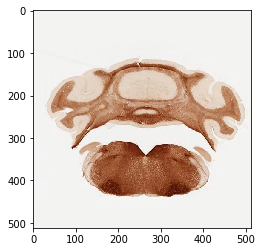

In [0]:
# original image
 
img = cv2.imread('aug_data/0/0-165.jpg')
plt.imshow(img)

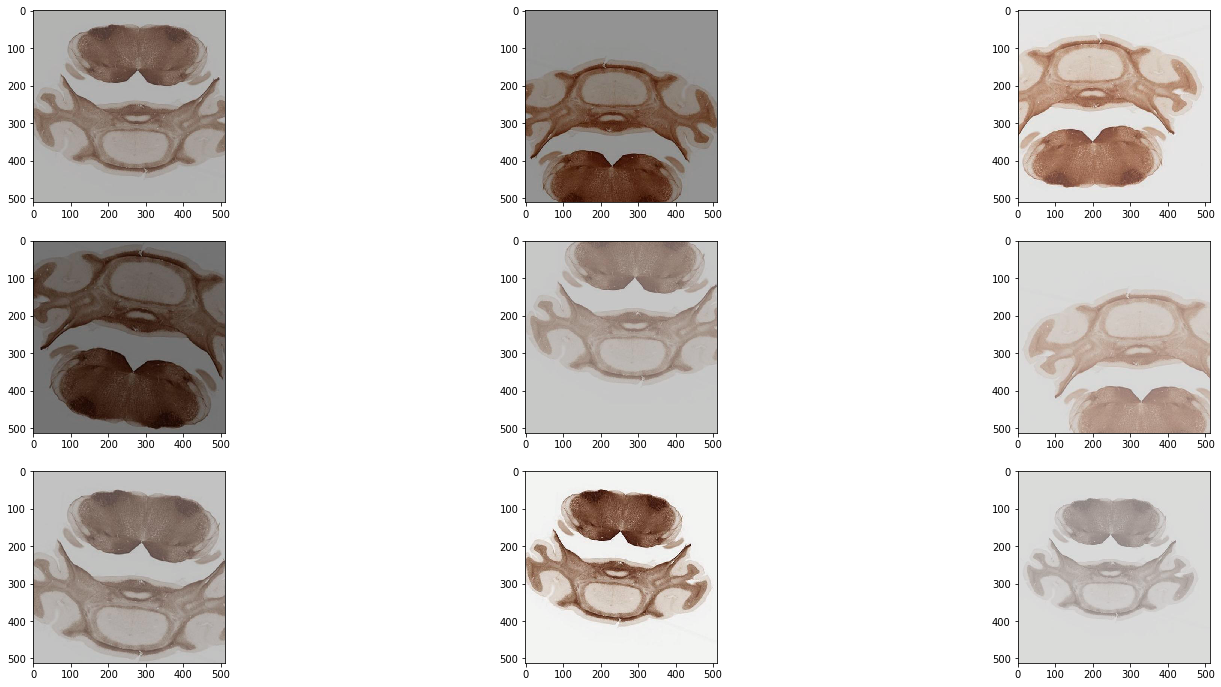

In [0]:
paths = []

for root, dirs, files in os.walk('aug_data/0/output'):
  for f in files:
    if f.startswith('0_original_0-165'):
      paths.append(os.path.join(root, f))

plot(paths[:-1], 3, 3)

***HOR***

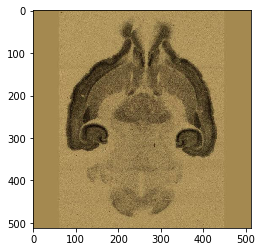

In [0]:
# original image
 
img = cv2.imread('aug_data/1/1-123.jpg')
plt.imshow(img)

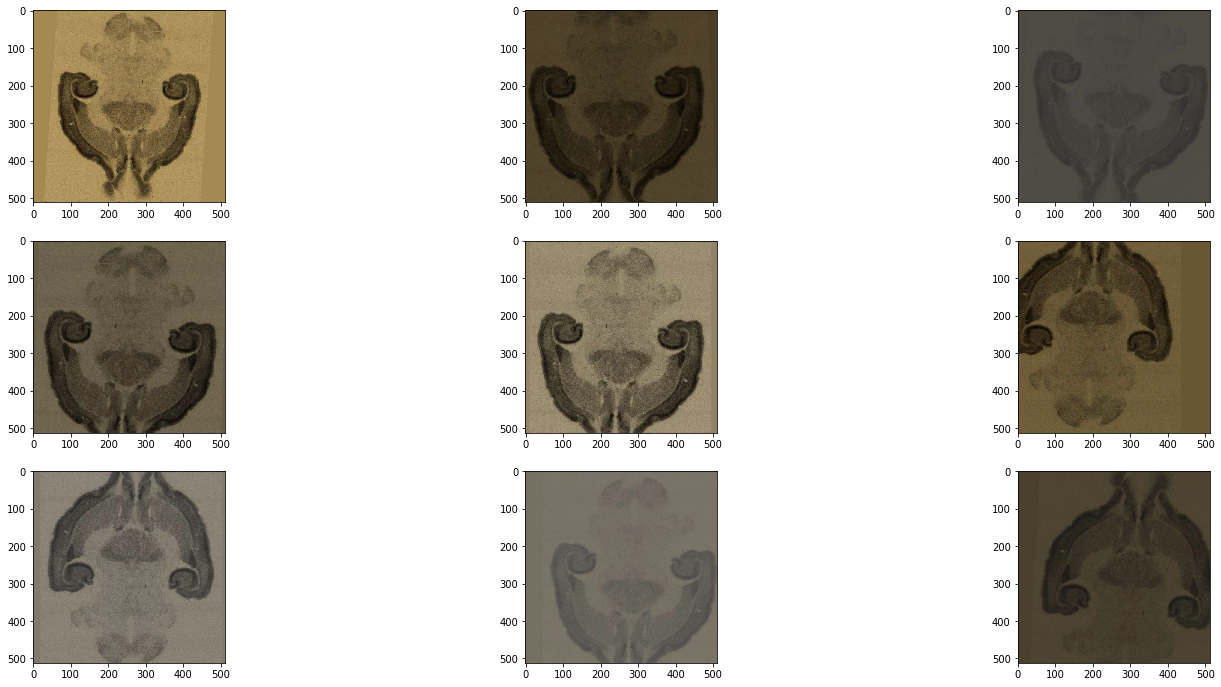

In [0]:
paths = []

for root, dirs, files in os.walk('aug_data/1/output'):
  for f in files:
    if f.startswith('1_original_1-123'):
      paths.append(os.path.join(root, f))

plot(paths[:9], 3, 3)

***SAG***

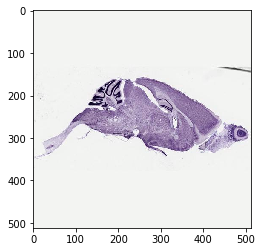

In [0]:
# original image
 
img = cv2.imread('aug_data/2/2-108.jpg')
plt.imshow(img)

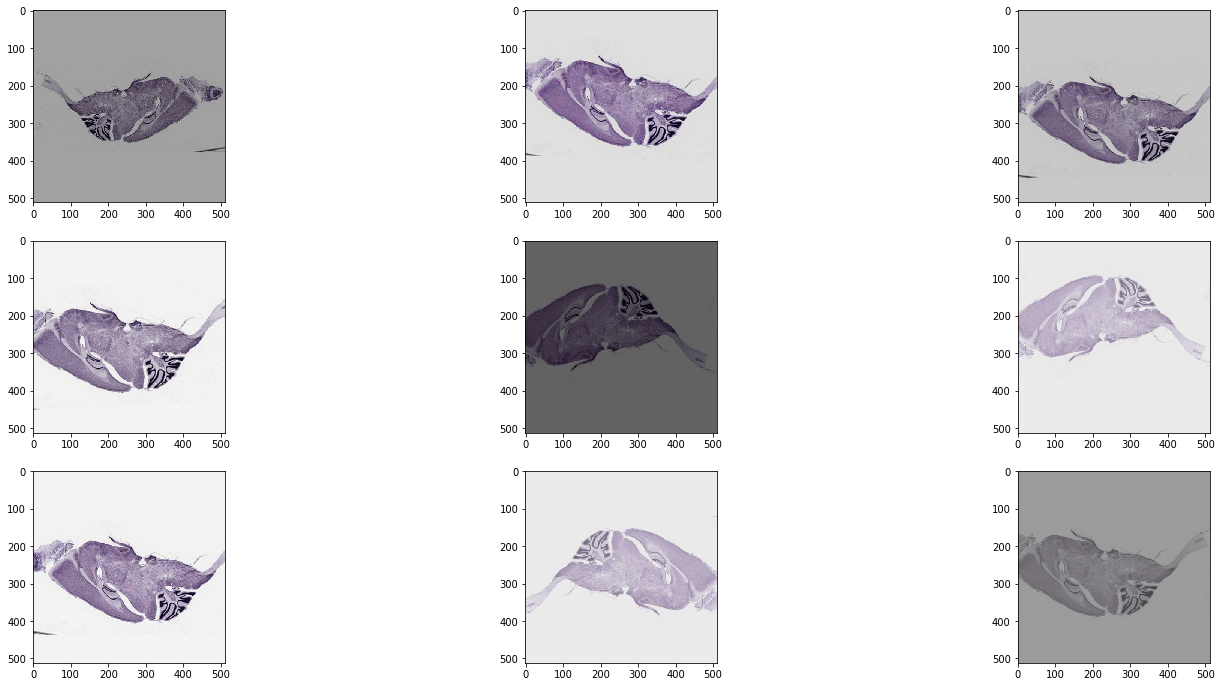

In [0]:
paths = []

for root, dirs, files in os.walk('aug_data/2/output'):
  for f in files:
    if f.startswith('2_original_2-108'):
      paths.append(os.path.join(root, f))

plot(paths[:9], 3, 3)

## 5.4 Combine Augmented Training Set With Original Training Set

In [0]:
import shutil

def move_file(src_dir,target_dir):
    if not os.path.exists(target_dir):
        os.mkdir(target_dir)

    for item in os.listdir(src_dir):
        src_name = os.path.join(src_dir,item)   
        target_name = os.path.join(target_dir,item)
        shutil.move(src_name,target_name)

In [0]:
src_dir = 'aug_data/0/output'
target_dir = 'aug_data/cor'
move_file(src_dir, target_dir)

In [0]:
src_dir = 'aug_data/1/output'
target_dir = 'aug_data/hor'
move_file(src_dir, target_dir)

In [0]:
src_dir = 'aug_data/2/output'
target_dir = 'aug_data/sag'
move_file(src_dir, target_dir)

#### Modify the prepare_data() function to make sure original training set and augmented training set are both loaded for training

In [0]:
def prepare_data(PATH, AUG_PATH, hparams):
  """Load, split, resize and normalize data"""
  
  X, y = load_data(PATH, hparams[HP_IMAGESIZE])
  aug_X, aug_y = load_data(AUG_PATH, hparams[HP_IMAGESIZE])
  X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)
  X_full = np.concatenate((X_train, aug_X), axis=0)
  y_full = np.concatenate((y_train, aug_y), axis=0)
  
  print('Shape of input of train set after augmentation is {}, val set is {}, test set is {}'.format(X_full.shape, X_val.shape, X_test.shape))
  print('Shape of label of train set after augmentation is {}, val set is {}, test set is {}'.format(y_full.shape, y_val.shape, y_test.shape))

# 6. TRAIN SELECTED MODEL STRUCTURE WITH AUGMENTED DATA

## 6.1 Code Add-ons


### Add other options for HP_STRUCTURE  and HP_OPTIMIZER in the code based on hyperparameter tuning code for final model run. I don't copy that long code again here, below is a little additional add-on to that long code

In [0]:
# elif hparams[HP_STRUCTURE] == 'ReplaceTop_1Dense_Reg':
      
#     # build base model from InceptionV3 and exclude the top layer
#     base_model = tf.keras.applications.InceptionV3(input_shape=shape,
#                                                   include_top=False,
#                                                   weights='imagenet')
#     # freeze all layers of base model
#     base_model.trainable = False


#     # combine base and top model and compile
#     model = Sequential([base_model,
#                         GlobalAveragePooling2D(name='avg_pool'),
#                         Dropout(0.3),
#                         Dense(CLASS_NUM, activation='softmax', name='predictions')])
    
    
# elif hparams[HP_STRUCTURE] == 'ReplaceTop_2Dense_Reg': 
#     # build base model from InceptionV3 and exclude the top layer
#     base_model = tf.keras.applications.InceptionV3(input_shape=shape,
#                                                    include_top=False,
#                                                    weights='imagenet')
#     # freeze all layers of base model
#     base_model.trainable = False

#     if hparams[HP_ACTIVATION] == 'elu':
#       act = tf.keras.layers.ELU(alpha=1.0)
      
#     elif hparams[HP_ACTIVATION] == 'relu':
#       act = 'relu'

#     # combine base and top model and compile
#     model = Sequential([base_model,
#                         GlobalAveragePooling2D(name='avg_pool'),
#                         Dense(hparams[HP_UNITS], activation=act, name='fc'),
#                         Dropout(0.5),
#                         Dense(CLASS_NUM, activation='softmax', name='predictions')])
  


In [0]:
# elif hparams[HP_OPTIMIZER] == 'Adam-decay':
#    opt = Adam(lr=hparams[HP_LEARNINGRATE], beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)

## 6.2 Comparison Of Results

#### Model 1: 
* Structure: InceptionV3 (exclude Top) + 1 Pooling + 1 Droput (0.3) + 1 Dense
* Optimizer: SGD
* Learning Rate: 1e-2 with decay 1e-6
* Image Size: 512
* Batch Size: 128
* Epochs: 50
* Data: Augmented Training Data Set (3, 022 Examples)

<img class="tfo-display-only-on-site" src="https://github.com/ziqlu0722/Mouse-Brain-Image-Classifier/blob/master/hparam_tensorboard/1fc_reg.png?raw=1"/>


#### Model 2: 
* Structure: InceptionV3 (exclude Top) + 1 Pooling + 1Dense + 1 Droput (0.8) + 1 Dense
* Optimizer: Adam
* Learning Rate: 1e-3 with decay 1e-6
* Image Size: 512
* Units: 512
* Activation: relu
* Batch Size: 128
* Epochs: 50
* Data: Augmented Training Data Set (3, 022 Examples)

<img class="tfo-display-only-on-site" src="https://github.com/ziqlu0722/Mouse-Brain-Image-Classifier/blob/master/hparam_tensorboard/2fc_reg.png?raw=1"/>

### Apprently, Model 1 is more stable compared with Model 2, who has a lot of fluctuations for validation loss and accuracy. I will use Model 1 for this task to predict out-of-sample images

# 7. EVALUATION

## 7.1 Load Saved Model Weights And Predict An Unseen Example

In [0]:
def load_model(ckp_path):
  
  shape = (512, 512, 3) 

  # build base model from InceptionV3 and exclude the top layer
  base_model = tf.keras.applications.InceptionV3(input_shape=shape,
                                                 include_top=False,
                                                 weights='imagenet')
  # freeze all layers of base model
  base_model.trainable = False

  # combine base and top model and compile
  model = Sequential([base_model,
                      GlobalAveragePooling2D(name='avg_pool'),
                      Dropout(0.3),
                      Dense(3, activation='softmax', name='predictions')])

  print('[INFO] Created model and loading weights from file {} ...'.format(ckp_path))
  model.load_weights(ckp_path)
  
  opt = SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True)
   
  model.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  print('[INFO] Successfully loaded!')
  return model


def predict(ckp_path, test_data):
  """ This predict() function will call load_model() function to fulfill prediction function
  
  Args:
    ckp_path: the path of checkpoint need to be loaded
    test_data: a numpy array of shape (N, 512, 512, 3), where N is the number of images to be predicted
    
  """
  model = load_model(ckp_path)
  pred_prob = model.predict_proba(test_data)
  pred_y = list(model.predict_classes(test_data))
  
  return pred_prob, pred_y, model

In [0]:
ckp_path = 'logs/ckp/1fc_reg/checkpoint-50-val_acc_0.91.hdf5'
test_data = X_val
pred_prob, pred_y, model = predict(ckp_path, test_data)

[INFO] Created model and loading weights from file logs/ckp/1fc_reg/checkpoint-50-val_acc_0.91.hdf5 ...
[INFO] Successfully loaded!


#### Each float in a row represents the probability of the image being sliced coronally, horizontally, and sagittally

In [0]:
pred_prob[:5]

array([[0.83895963, 0.1568167 , 0.00422366],
       [0.8734765 , 0.12159156, 0.004932  ],
       [0.80403566, 0.1921264 , 0.00383799],
       [0.10743266, 0.0519637 , 0.84060365],
       [0.8192207 , 0.1639307 , 0.01684853]], dtype=float32)

In [0]:
pred_y[:5]

[0, 0, 0, 2, 0]

## 7.2 Performance Review

In [0]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def accuracy(pred_y, true_y):
  """this calculates the accuracy of the model prediction on test set
  
  Args:
    pred_y: generated by predict(), a list of integers representing predicted lables
    true_y: list of integers representing true lables
    
  """
  error = 0
  for i in range(len(true_y)):
    if pred_y[i] != true_y[i]:
      error += 1
      
  accuracy = (len(true_y)-error)/len(true_y)

  return accuracy


def print_confusion_matrix(confusion_matrix, class_names, figsize = (7,5), fontsize=12):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Args:
      confusion_matrix: numpy.ndarray, returned from a call to sklearn.metrics.confusion_matrix
      class_names: list, An ordered list of class names, in the order they index the given confusion matrix.
      
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

def evaluate(pred_y, true_y):
  """ This evaluate function calls accuracy to print the accuracy level 
      and calls print_confusion_matrix function to print confusion matrix
      
  Args:
      pred_y: generated by predict(), a list of integers representing predicted lables
      true_y: list of integers representing true lables
      
  """
  
  print('The accuracy of this model on test set is percent:{:.2%}'. format(accuracy(pred_y, true_y)))
  print('______________________________________________________________________________')

  cm = confusion_matrix(true_y, pred_y, labels=None, sample_weight=None)
  class_names = ['cor', 'hor', 'sag']
  print_confusion_matrix(cm, class_names)

The accuracy of this model on test set is percent:92.91%
______________________________________________________________________________


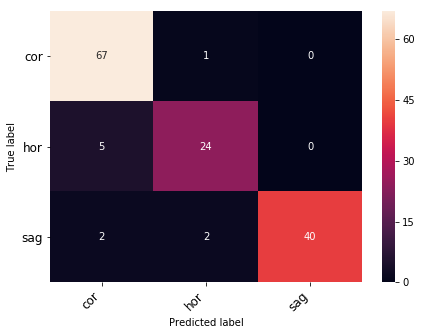

In [0]:
true_y = list(y_val.argmax(axis=1))
evaluate(pred_y, true_y)

## 7.3 Main Function For Image Classification

#### Each float in a row represents the probability of the image being sliced coronally, horizontally, and sagittally

In [0]:
# those parameters must be given to make prediction and evaluation work

# define the checkpoint path
ckp_path = 'logs/ckp/1fc_reg/checkpoint-50-val_acc_0.91.hdf5'

# define the test data (N, 512, 512, 3)
test_X = X_test

# main function define
def main():
  
  pred_prob, pred_y, model = predict(ckp_path, test_X)

  print(np.array_str(pred_prob, precision=3, suppress_small=True))
  
main()

[INFO] Created model and loading weights from file logs/ckp/1fc_reg/checkpoint-50-val_acc_0.91.hdf5 ...
[INFO] Successfully loaded!
[[0.074 0.077 0.849]
 [0.426 0.338 0.236]
 [0.452 0.541 0.007]
 [0.774 0.169 0.058]
 [0.904 0.093 0.003]
 [0.059 0.014 0.927]
 [0.049 0.947 0.004]
 [0.206 0.79  0.004]
 [0.086 0.013 0.901]
 [0.322 0.155 0.522]
 [0.823 0.169 0.007]
 [0.228 0.07  0.702]
 [0.394 0.606 0.001]
 [0.95  0.05  0.   ]
 [0.513 0.479 0.009]
 [0.86  0.135 0.005]
 [0.189 0.205 0.606]
 [0.656 0.341 0.003]
 [0.206 0.213 0.581]
 [0.258 0.739 0.004]
 [0.853 0.12  0.027]
 [0.108 0.137 0.755]
 [0.8   0.2   0.   ]
 [0.749 0.247 0.003]
 [0.297 0.097 0.606]
 [0.936 0.053 0.011]
 [0.541 0.455 0.004]
 [0.087 0.09  0.823]
 [0.068 0.931 0.001]
 [0.86  0.112 0.028]
 [0.849 0.148 0.003]
 [0.754 0.173 0.073]
 [0.184 0.815 0.002]
 [0.3   0.7   0.001]
 [0.742 0.21  0.047]
 [0.117 0.062 0.82 ]
 [0.702 0.216 0.082]
 [0.039 0.014 0.947]
 [0.708 0.278 0.014]
 [0.204 0.588 0.208]
 [0.061 0.247 0.692]
 [0.039

# 8. REVIEW OF THIS TASK AND FUTURE IMPROVEMENTS

> In this task, an accuracy level of more than 90% on out-of-sample test set is achieved with a tiny data set.

> In this task, only 422 original images are used for training, data augmentation helps the training set increase to 3022. 
  
 * In fact, in the final stage, I should have use training and validation data set together as the final training data set to produce a more robust model with more data points. Besides, data augmentation could also be applied to the whole final training set. Those are possible future actions to improve model robustness 
  
> Data augmentation helps a lot with validation set accuracy, without data augmentation, accuracy is far lower and unstable even with the best models when tuning the hyperparameters. (0.7 vs. 0.9)

* In the future, Some other data augmentation methods could be tested. Like guassian noise, color jittering, etc.
  
> Different model structures are explored. It turns out remove top and connected a new top with 1 pooling - 1 dropout - 1 prediction layer works best among them. This applied structure introduced 6000+ new parameters to be trained, somewhere in between other two basic structure

* More detailed tuning for layers could be done in the future. For example, different choices of pooling layer, max, average, global, or setting strides
  
> Different image sizes are also expolred for hyparam tuning. 512 works good, while in tuning stage, the gap between it and some good models with 128/256 are not that bad

* Worth tring smaller input sizes on large dataset to see if we could leverage efficiency. In this task, 512 input sizes kept making kernel crashed down

> To prevent overfitting, several regularizaiton method are used here - data augmentation, drop out layer, learning rate decay...

* In the future, more regularization method could be tested to see if greater results will be achieved

> Tensorboard is a really nice tool

* This is the first time I use Tensorboard for hyperparameter tuning. I have to say it is a really nice tool, make the tuning process so organized, and I should use it more in the future